In [22]:
import pandas as pd
import numpy as np
import os
import json
import seaborn as sns
import matplotlib.pyplot as plt

from simpletransformers.classification import ClassificationModel, ClassificationArgs
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

from sklearn.model_selection import StratifiedKFold
from simpletransformers.classification import ClassificationModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

from scipy.special import softmax
from scipy.stats import pearsonr

In [11]:
import re
import string

def remove_emojis(text):
    return ''.join(char for char in text if char in (string.ascii_letters + string.digits + string.punctuation + ' '))

def remove_tags(text):
    return re.sub(r'@\w+', '', text)

def remove_multispace(text):
    return re.sub(r'[\s]+|[\t]|[.,"\']', ' ', text)

def preprocess_pipeline(text):

    text = remove_emojis(text)
    text = remove_tags(text)
    text = remove_multispace(text)

    return text

In [12]:
olid = pd.read_csv('data/olid-train-small.csv')
olid['text'] = olid['text'].apply(preprocess_pipeline)

test_data = pd.read_csv('data/olid-test.csv')
test_data['text'] = test_data['text'].apply(preprocess_pipeline)

In [13]:
model_args = ClassificationArgs()
model_args.train_batch_size = 8
model_args.num_train_epochs = 3
model_args.learning_rate = 1e-4
model_args.warmup_ratio = 0.1
model_args.evaluate_during_training_steps = 20
model_args.evaluate_during_training = True
model_args.evaluate_during_training_verbose = True
model_args.use_early_stopping = True
model_args.early_stopping_patience = 20 #this was increased to 20, not 10 as in fbret paper
#utilities:

model_args.save_eval_checkpoints = False
model_args.overwrite_output_dir = True
model_args.use_multiprocessing=False
model_args.use_multiprocessing_for_evaluation=False

os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [23]:
def results(predictions, true_labels, file_path):
    # metrics: precision, recall, f1-score
    metrics = classification_report(y_true=true_labels, y_pred=predictions)
    # confusion matrix
    cm = confusion_matrix(true_labels, predictions)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')

    # Save the heatmap as an image
    plt.savefig(file_path + '_confusion_matrix.png')
    # Serialize and save the dictionary to a file
    with open(file_path + "metrics.json", "w") as file:
        json.dump(metrics, file)

    file.close()

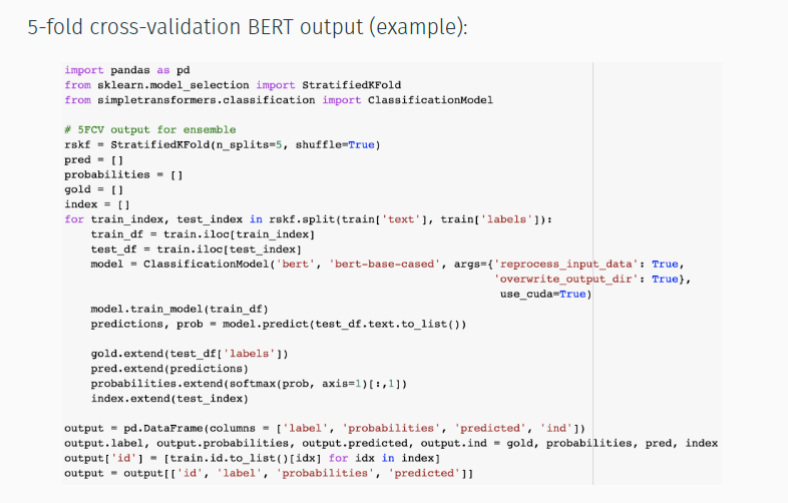


In [15]:
# Data 

X_test = test_data['text']
y_test = test_data['labels']

# Initialize meta-models
meta_model_rf = RandomForestClassifier()
meta_model_lr = LogisticRegression()

# Initialize StratifiedKFold cross-validator
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)


# Initialize arrays to store meta-features (base predictions) and true labels
meta_features = []
true_labels = []

# Perform StratifiedKFold cross-validation
for train_index, val_index in skf.split(olid['text'], olid['labels']):
    # this is data that be used for training transformers and it will be split
    # to eval and train so that early stoppings can be used.
    train_transformers = olid.iloc[train_index]
    # evaluation data split for training transformers:
    eval_data = train_transformers.sample(frac=0.15, random_state=42)
    # training data for transformers
    train_data = train_transformers.drop(eval_data.index)
    
    #this data will be used for making predictions with transformers
    #these prediction will then be plugged to meta model for further training
    train_meta = olid.iloc[val_index]  
    
    #initialize the models 
    model_args.best_model_dir ='outputs1/bert_olid_stack'
    bert_model_olid = ClassificationModel("bert", "bert-base-uncased", args=model_args, use_cuda=True)
    model_args.best_model_dir ='outputs2/hatebert_olid_stack'
    hatebert_model_olid = ClassificationModel('bert', 'GroNLP/hateBERT', args=model_args, use_cuda=True)
    model_args.best_model_dir ='outputs3/fbert_olid_stack'
    fbert_model_olid = ClassificationModel('bert', 'diptanu/fBERT', args=model_args, use_cuda=True)
    
    # Train base models
    bert_model_olid.train_model(train_data, eval_df=eval_data)
    hatebert_model_olid.train_model(train_data, eval_df=eval_data )
    fbert_model_olid.train_model(train_data, eval_df=eval_data)

    # Predict with base models on validation set
    preds_bert, probs_bert = bert_model_olid.predict(train_meta['text'].tolist())
    preds_hatebert, probs_hatebert = hatebert_model_olid.predict(train_meta['text'].tolist())
    preds_fbert, probs_fbert = fbert_model_olid.predict(train_meta['text'].tolist())
    
    #transforming model prediction outputs to probabilities with softmax:
    softmax_bert = softmax(probs_bert, axis=1)[:,1]
    softmax_hatebert = softmax(probs_hatebert, axis=1)[:,1]
    softmax_fbert = softmax(probs_fbert, axis=1)[:,1]

    # Stack base model predictions
    stacked_features = np.column_stack((preds_bert, preds_hatebert, preds_fbert,
                                        softmax_bert, softmax_hatebert, softmax_fbert))

    # Store true labels and meta-features
    true_labels.extend(train_meta['labels'].tolist())
    meta_features.extend(stacked_features)
    

# Train meta-models on the stacked features
meta_model_rf.fit(meta_features, true_labels)
meta_model_lr.fit(meta_features, true_labels)

# Predict with base models on test set
base_preds_bert, base_probs_bert = bert_model_olid.predict(X_test.tolist())
base_preds_hatebert, base_probs_hatebert = hatebert_model_olid.predict(X_test.tolist())
base_preds_fbert, base_probs_fbert = fbert_model_olid.predict(X_test.tolist())
#additional feature - probabilities from model outputs after softmax
base_softmax_bert = softmax(base_probs_bert, axis=1)[:,1]
base_softmax_hatebert = softmax(base_probs_hatebert, axis=1)[:,1]
base_softmax_fbert = softmax(base_probs_fbert, axis=1)[:,1]

# Stack base model predictions for test set
stacked_test_features = np.column_stack((base_preds_bert, base_preds_hatebert, base_preds_fbert,
                                        base_softmax_bert, base_softmax_hatebert,base_softmax_fbert))

# Use meta-models for final prediction
ensemble_preds_rf = meta_model_rf.predict(stacked_test_features)
ensemble_preds_lr = meta_model_lr.predict(stacked_test_features)

#results(ensemble_preds_rf, test_data['labels'], file_path='results/stacked_ensemble_olid_results')

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/hateBERT and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at diptanu/fBERT and are newly initialized: ['classifier.weight', 'bert.pooler.dense.weight', 'bert.pooler.dense.bias', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 0 of 3:   0%|          | 0/498 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/498 [00:00<?, ?it/s]

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 0 of 3:   0%|          | 0/498 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/498 [00:00<?, ?it/s]

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 0 of 3:   0%|          | 0/498 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/498 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/hateBERT and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at diptanu/fBERT and are newly initialized: ['classifier.weight', 'bert.pooler.dense.weight', 'bert.pooler.dense.bias', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 0 of 3:   0%|          | 0/498 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/498 [00:00<?, ?it/s]

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 0 of 3:   0%|          | 0/498 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/498 [00:00<?, ?it/s]

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 0 of 3:   0%|          | 0/498 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/498 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/hateBERT and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at diptanu/fBERT and are newly initialized: ['classifier.weight', 'bert.pooler.dense.weight', 'bert.pooler.dense.bias', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 0 of 3:   0%|          | 0/498 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/498 [00:00<?, ?it/s]

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 0 of 3:   0%|          | 0/498 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/498 [00:00<?, ?it/s]

Running Epoch 2 of 3:   0%|          | 0/498 [00:00<?, ?it/s]

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 0 of 3:   0%|          | 0/498 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/498 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/hateBERT and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at diptanu/fBERT and are newly initialized: ['classifier.weight', 'bert.pooler.dense.weight', 'bert.pooler.dense.bias', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 0 of 3:   0%|          | 0/498 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/498 [00:00<?, ?it/s]

Running Epoch 2 of 3:   0%|          | 0/498 [00:00<?, ?it/s]

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 0 of 3:   0%|          | 0/498 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/498 [00:00<?, ?it/s]

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 0 of 3:   0%|          | 0/498 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/hateBERT and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at diptanu/fBERT and are newly initialized: ['classifier.weight', 'bert.pooler.dense.weight', 'bert.pooler.dense.bias', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 0 of 3:   0%|          | 0/498 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/498 [00:00<?, ?it/s]

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 0 of 3:   0%|          | 0/498 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/498 [00:00<?, ?it/s]

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 0 of 3:   0%|          | 0/498 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/498 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

### get correlations of model

In [16]:
# Calculate correlations using scipy's pearsonr function
correlation_bert_hatebert = pearsonr(base_preds_bert, base_preds_hatebert)
correlation_bert_fbert = pearsonr(base_preds_bert, base_preds_fbert)
correlation_hatebert_fbert = pearsonr(base_preds_hatebert, base_preds_fbert)

# putting correlations to dataframe:

In [17]:
base_preds_bert

[0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,


In [18]:
dict_correlation_bert_hatebert = {"corr": correlation_bert_hatebert[0],
                                 "p-value":correlation_bert_hatebert[1]}
dict_correlation_bert_fbert = {"corr": correlation_bert_fbert[0],
                                 "p-value":correlation_bert_fbert[1]}
dict_correlation_hatebert_fbert = {"corr": correlation_hatebert_fbert[0],
                                 "p-value":correlation_hatebert_fbert[1]}

corr_indomain_df = pd.DataFrame([dict_correlation_bert_hatebert,dict_correlation_bert_fbert,dict_correlation_hatebert_fbert],
            index=['bert_hatebert','bert_fbert','hatebert_fbert'])

corr_indomain_df
#corr_indomain_df.to_csv('subjMining5/results/in-domain/stacked/in_domain_model_correlations_stacked.csv')

,corr,p-value
bert_hatebert,0.725713,1.671792e-141
bert_fbert,0.693950,1.572028e-124
hatebert_fbert,0.759893,1.151113e-162


### save predictions

In [20]:
predictions_df = test_data
predictions_df['stacked_random_forest_predictions'] = ensemble_preds_rf
predictions_df['stacked_logistic_regression_predictions'] = ensemble_preds_lr
predictions_df.to_csv('results/in-domain/stacked/in_domain_predictions_stacked_rf_lr.csv')

### get classification metrics and confusion matrix

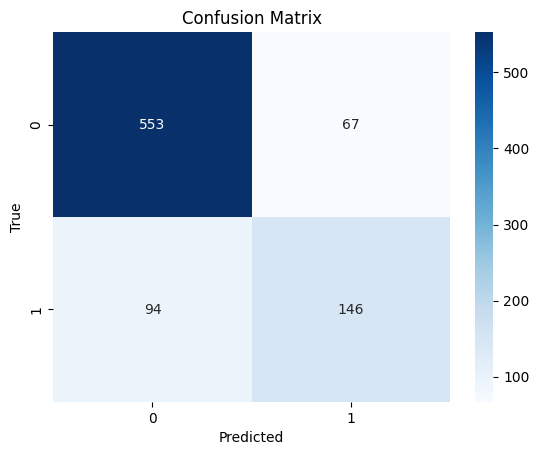

In [24]:
results(ensemble_preds_rf, test_data['labels'], file_path='results/in-domain/stacked/in_domain_stacked_rf_results')

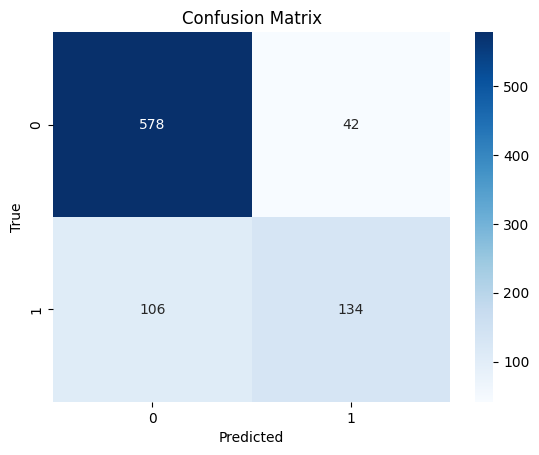

In [25]:
results(ensemble_preds_lr, test_data['labels'], file_path='results/in-domain/stacked/in_domain_stacked_lr_results')